# Zipline Backtest with Single Factor 

This notebook develops and test a simple mean-reversion factor that measures how much recent performance has deviated from the historical average. Short-term reversal is a common strategy that takes advantage of the weakly predictive pattern that stock price increases are likely to mean-revert back down over horizons from less than a minute to one month.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')

We are first going to illustrate the zipline alpha factor research workflow in an offline environment. In particular, we will develop and test a simple mean-reversion factor that measures how much recent performance has deviated from the historical average. 

Short-term reversal is a common strategy that takes advantage of the weakly predictive pattern that stock price increases are likely to mean-revert back down over horizons from less than a minute to one month.

To this end, the factor computes the z-score for the last monthly return relative to the rolling monthly returns over the last year. At this point, we will not place any orders to simply illustrate the implementation of a CustomFactor and record the results during the simulation.

After some basic settings, `MeanReversion` subclasses `CustomFactor` and defines a `compute()` method. It creates default inputs of monthly returns over an also default year-long window so that the monthly_return variable will have 252 rows and one column for each security in the Quandl dataset on a given day.

The `compute_factors()` method creates a `MeanReversion` factor instance and creates long, short, and ranking pipeline columns. The former two contain Boolean values that could be used to place orders, and the latter reflects that overall ranking to evaluate the overall factor performance. Furthermore, it uses the built-in `AverageDollarVolume` factor to limit the computation to more liquid stocks

The result would allow us to place long and short orders. We will see in the next chapter how to build a portfolio by choosing a rebalancing period and adjusting portfolio holdings as new signals arrive.

- The `initialize()` method registers the compute_factors() pipeline, and the before_trading_start() method ensures the pipeline runs on a daily basis. 
- The `record()` function adds the pipeline's ranking column as well as the current asset prices to the performance DataFrame returned by the `run_algorithm()` function

Run using jupyter notebook extension

In [13]:
%load_ext zipline

The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline


Using the `quandl` bundle instead of the default `quantopian-quandl` because the latter has a bug that requires (manually) fixing the SQL database. If you have a file with benchmark returns you can provide this instead of `--no-benchmark` (see [docs](https://github.com/stefan-jansen/zipline/blob/master/docs/source/whatsnew/1.4.0.txt)).

## Inspect Results

We can get the result `DataFrame` using `_` which captures the last cell output (only works when you run it right after the above cell)

In [4]:
import pandas as pd
result = pd.read_pickle('../buyapple_out.pickle') # read in perf DataFrame
result.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 503 entries, 2016-01-04 21:00:00+00:00 to 2017-12-29 21:00:00+00:00
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   period_open              503 non-null    datetime64[ns, UTC]
 1   period_close             503 non-null    datetime64[ns, UTC]
 2   positions                503 non-null    object             
 3   gross_leverage           503 non-null    float64            
 4   starting_exposure        503 non-null    float64            
 5   net_leverage             503 non-null    float64            
 6   ending_exposure          503 non-null    float64            
 7   starting_value           503 non-null    float64            
 8   ending_value             503 non-null    float64            
 9   starting_cash            503 non-null    float64            
 10  ending_cash              503 non-null    float64 

In [5]:
result.index = pd.to_datetime(result.index)


In [8]:
result[['factor_data']].iloc[0,0]

Equity(0 [A])           321.0
Equity(2 [AAL])        1156.0
Equity(7 [AAP])        1556.0
Equity(8 [AAPL])       2547.0
Equity(12 [ABBV])       438.0
                        ...  
Equity(3180 [ZBH])      543.0
Equity(3181 [ZBRA])    2072.0
Equity(3188 [ZION])    2416.0
Equity(3189 [ZIOP])    2486.0
Equity(3197 [ZTS])      413.0
Name: ranking, Length: 1000, dtype: float64

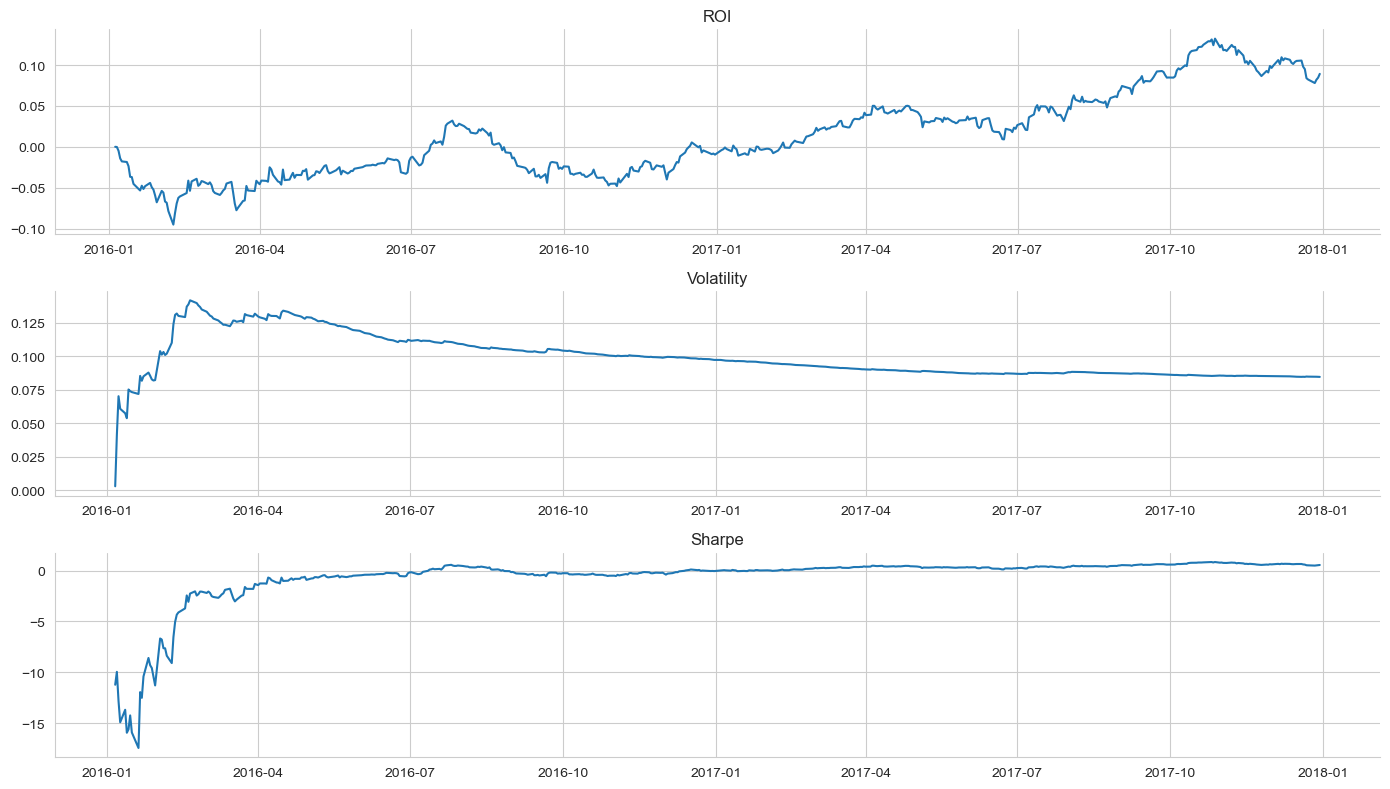

In [9]:
fig, axes = plt.subplots(nrows=3, figsize=(14,8))
result.index = pd.to_datetime(result.index)
result.index = result.index.tz_localize(None)

output = result[['algorithm_period_return']].to_numpy()
output2 = result[['algo_volatility']].to_numpy()
output3 = result[['sharpe']].to_numpy()
x = result.index
axes[0].plot(x,output)
axes[0].set_title('ROI')
axes[1].plot(x,output2)
axes[1].set_title('Volatility')
axes[2].plot(x,output3)
axes[2].set_title('Sharpe')
sns.despine()
fig.tight_layout();

In [10]:
ROI = ((result[['ending_cash']].iloc[-1,0] / result[['starting_cash']].iloc[0,0] - 1) / result[['trading_days']].iloc[-1,0]) * 365
print(f"Effective yearly ROI: {round(ROI * 100, 2)}%")

Effective yearly ROI: 14.62%


In [11]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import numpy as np
import collections
import time
%matplotlib inline

def live_plot(x, y, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    plt.barh(x, y)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('Amounts')
    plt.legend(loc='center left') # the plot evolves to the right
    plt.show();
    time.sleep(1);


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


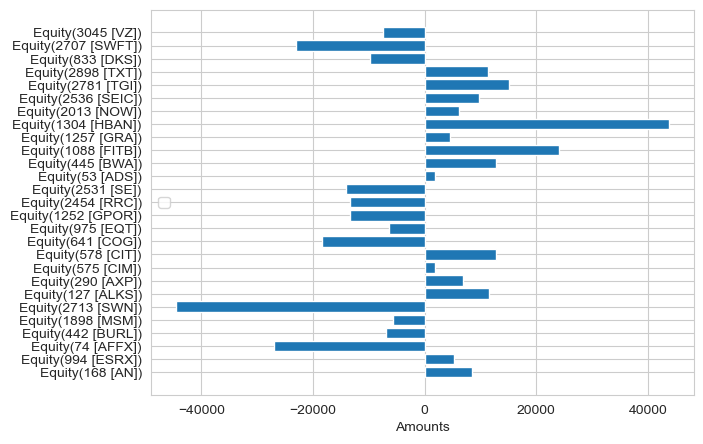

KeyboardInterrupt: 

In [12]:
for i in range(1, (result[['positions']].shape[0])):
    positions = result[['positions']].iloc[i,0]
    tickers = []
    amounts = []
    for position in positions:
        tickers.append(str(position['sid']))
        amounts.append(position['amount'])
    live_plot(tickers, amounts)

In [127]:
def analyze(context, perf):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    perf.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel('portfolio value in $')

    ax2 = fig.add_subplot(212)
    perf['AAPL'].plot(ax=ax2)
    perf[['short_mavg', 'long_mavg']].plot(ax=ax2)

    perf_trans = perf.loc[[t != [] for t in perf.transactions]]
    buys = perf_trans.loc[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
    sells = perf_trans.loc[
        [t[0]['amount'] < 0 for t in perf_trans.transactions]]
    ax2.plot(buys.index, perf.short_mavg.loc[buys.index],
             '^', markersize=10, color='m')
    ax2.plot(sells.index, perf.short_mavg.loc[sells.index],
             'v', markersize=10, color='k')
    ax2.set_ylabel('price in $')
    plt.legend(loc=0)
    plt.show()

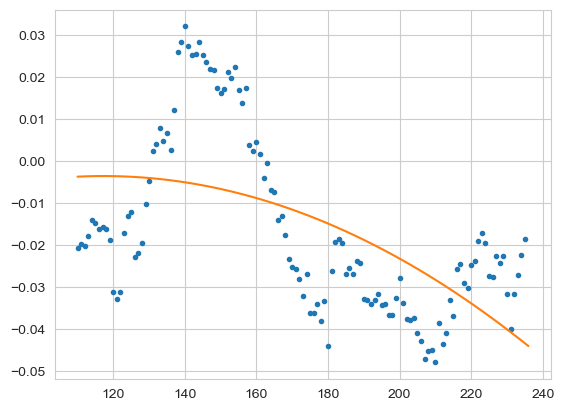

In [73]:
#Testing Polyfit function:
#126 days in a 6-month period
import numpy as np
n = 110
period = 126
y = result[['algorithm_period_return']].iloc[n:n+period,0].to_numpy()
x = result[['algorithm_period_return']].reset_index().index[n:n+period].to_numpy()

z = np.polyfit(x, y, 2)
p = np.poly1d(z)
xp = np.linspace(n, n+period)

_ = plt.plot(x, y, '.', xp, p(xp))
plt.show()

In [61]:
trend = (p(n+period) - p(n)) / period

-0.0003202923730287463

In [63]:
#RSI creation block
result['change'] = result['algorithm_period_return'].diff()

result = result.reset_index()
change = result.change.tolist()
rsi = []

for index, row in result.iterrows():
    rsi_period = 14
    pos_sum = 0
    neg_sum = 0
    count = 0
    for j in range(rsi_period):
        try:
            if change[index - j] >= 0:
                pos_sum += change[index - j]
            elif change[index - j] < 0:
                neg_sum -= change[index - j]
            count += 1
        except:
            continue;
    if count == 0:
        rsi.append(np.nan)
    else:
        rsi_val = 100 - ( 100 / (1 + (pos_sum / neg_sum)))
        rsi.append(rsi_val)

result['rsi'] = pd.DataFrame(rsi)

#Testing Polyfit function:
#126 days in a 6-month period
#RSI
import numpy as np
n = 126
period = 126
y_rsi = result[['rsi']].iloc[n:n+period,0].to_numpy()
x_rsi = result[['rsi']].reset_index().index[n:n+period].to_numpy()

z_rsi = np.polyfit(x_rsi, y_rsi, 2)
p_rsi = np.poly1d(z_rsi)
xp_rsi = np.linspace(n, n+period)

#Prices
y = result[['algorithm_period_return']].iloc[n:n+period,0].to_numpy()
x = result[['algorithm_period_return']].reset_index().index[n:n+period].to_numpy()

z = np.polyfit(x, y, 2)
p = np.poly1d(z)
xp = np.linspace(n, n+period)

fig, axes = plt.subplots(2)

axes[0].plot(x, y, '.', xp, p(xp))
axes[1].plot(x_rsi, y_rsi, '.', xp_rsi, p_rsi(xp_rsi))
price_trend = round((p(n+period) - p(n)) / period, 4)
rsi_trend = round((p_rsi(n+period) - p_rsi(n)) / period, 2)

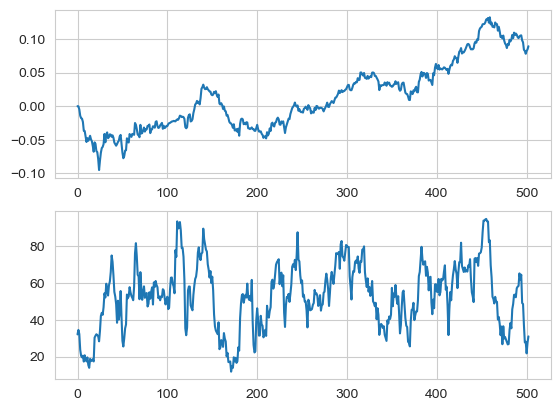

In [72]:
fig, axes = plt.subplots(2)
axes[0].plot(result.index, result['algorithm_period_return'])
axes[1].plot(result.index, result['rsi'])

The price trend is: -0.0003 
The RSI trend is: 0.06
Buy condition


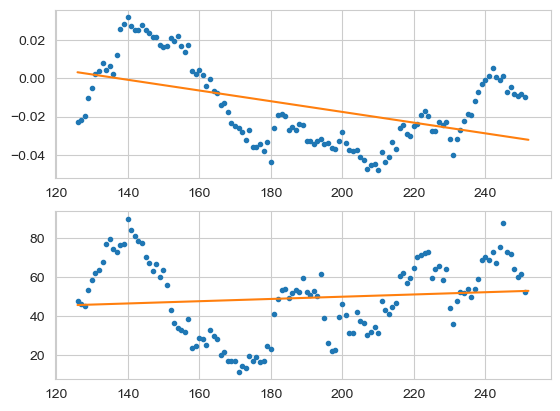

In [113]:
#Testing Polyfit function:
#126 days in a 6-month period
#RSI
import numpy as np
n = 126
period = 126
y_rsi = clean_df[['rsi']].iloc[n:n+period,0].to_numpy()
x_rsi = clean_df[['rsi']].reset_index().index[n:n+period].to_numpy()

z_rsi = np.polyfit(x_rsi, y_rsi, 1)
p_rsi = np.poly1d(z_rsi)
xp_rsi = np.linspace(n, n+period)

#Prices
y = result[['algorithm_period_return']].iloc[n:n+period,0].to_numpy()
x = result[['algorithm_period_return']].reset_index().index[n:n+period].to_numpy()

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
xp = np.linspace(n, n+period)

fig, axes = plt.subplots(2)

axes[0].plot(x, y, '.', xp, p(xp))
axes[1].plot(x_rsi, y_rsi, '.', xp_rsi, p_rsi(xp_rsi))
price_trend = round((p(n+period) - p(n)) / period, 4)
rsi_trend = round((p_rsi(n+period) - p_rsi(n)) / period, 2)
print(f"The price trend is: {price_trend} \nThe RSI trend is: {rsi_trend}")
if price_trend < 0 and rsi_trend > 0:
    print("Buy condition")
elif price_trend > 0 and rsi_trend < 0:
    print("Short condition")
elif price_trend > 0 and rsi_trend < 0:
    print("Do nothing")

In [100]:
pd.DataFrame(pd.Series(result[['algorithm_period_return']].iloc[:,0])).rename(columns={'algorithm_period_return': 'price'})

,price
2016-01-04 21:00:00+00:00,0.000000
2016-01-05 21:00:00+00:00,-0.000263
2016-01-06 21:00:00+00:00,-0.004894
2016-01-07 21:00:00+00:00,-0.014222
2016-01-08 21:00:00+00:00,-0.017872
...,...
2017-12-22 21:00:00+00:00,0.082230
2017-12-26 21:00:00+00:00,0.077958
2017-12-27 21:00:00+00:00,0.082009
2017-12-28 21:00:00+00:00,0.084517


In [109]:
pd.Series(result[['algorithm_period_return']].iloc[:,0]).to_numpy().shape

(503,)

In [110]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from datetime import datetime
import pandas as pd
import pandas_datareader.data as web

# replaces pyfinance.ols.PandasRollingOLS (no longer maintained)
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
idx = pd.IndexSlice

DATA_STORE = '../data/assets.h5'
START = 2010
END = 2018

with pd.HDFStore(DATA_STORE) as store:
    prices = (store['quandl/wiki/prices']
              .loc[idx[str(START):str(END), :], 'adj_close']
              .unstack('ticker'))
    #stocks = store['us_equities/stocks']

In [112]:
prices[['AAPL']]

ticker,AAPL
date,
2010-01-04,27.503268
2010-01-05,27.550818
2010-01-06,27.112585
2010-01-07,27.062465
2010-01-08,27.242385
...,...
2018-03-21,171.270000
2018-03-22,168.845000
2018-03-23,164.940000
